In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
"Hello"

## Molecular Pre-Energy

In [4]:
import os
import numpy as np
import glob
import torch
import time
from cace.cace.tools import scatter_sum
from cace.cace.tasks import LightningTrainingTask
from deeporb.data import OrbDataset, OrbData
from deeporb.ceonet import CEONet

#data
root = "data/aocart_occ.h5"
cutoff = 4.0
avge0 = -0.6637
sigma = 0.2863
data = OrbData(root=root,batch_size=128,cutoff=cutoff,avge0=avge0,sigma=sigma,in_memory=False)

representation = CEONet(64,cutoff=cutoff,n_rbf=8,n_rsamples=8,lomax=2,layers=4)

from cace.cace.models import NeuralNetworkPotential
from deeporb.atomwise import Atomwise, AttentionAtomwise
atomwise = AttentionAtomwise(
                    output_key='pred_energy',
                    n_hidden=[32,16],
                    attention_hidden_nc=128,
                    avge0=avge0,sigma=sigma,
                    bias=True
                   )

model = NeuralNetworkPotential(
    input_modules=None,
    representation=representation,
    output_modules=[atomwise]
)

chkpt = "/home/king1305/ORBITAL_LABELING/model_eval/gathered_logs/ceonet_occ/version_1/checkpoints/epoch=499-step=424500.ckpt"
task = LightningTrainingTask(model)
task.load(chkpt)

#Generate atomic representations
task.model.eval().cuda()
Xtot = []
with torch.no_grad():
    for batch in data.val_dataloader():
        batch.cuda()
        dct = task.model.model.representation(batch)
        Xrep = scatter_sum(src=dct["node_feats"],index=dct["batch"],dim=0)
        ones = torch.ones_like(batch["atomic_numbers"])
        num = scatter_sum(src=ones,index=dct["batch"],dim=0)
        Xrep = Xrep / num[:,None]
        Xtot.append(Xrep.cpu().detach().numpy())
del Xrep
del dct
torch.cuda.empty_cache()

ytot = []
task.model.eval().cuda()
with torch.no_grad():
    for batch in data.val_dataloader():
        batch.cuda()
        #,kwargs={"inference":True}
        dct = task.model.forward(batch) #Might have to ssh?
        ytot.append(dct["pred_energy"].cpu().detach().numpy())
torch.cuda.empty_cache()

Xtot = np.vstack(Xtot)
ytot = np.hstack(ytot)
#Undo scale-shift:
ytot = (ytot*sigma) + avge0
(Xtot.shape,ytot.shape)

Loading model from /home/king1305/ORBITAL_LABELING/model_eval/gathered_logs/ceonet_occ/version_1/checkpoints/epoch=499-step=424500.ckpt ...
Loading successful!


((12032, 1280), (12032,))

/tmp/ipykernel_3796498/3771929846.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


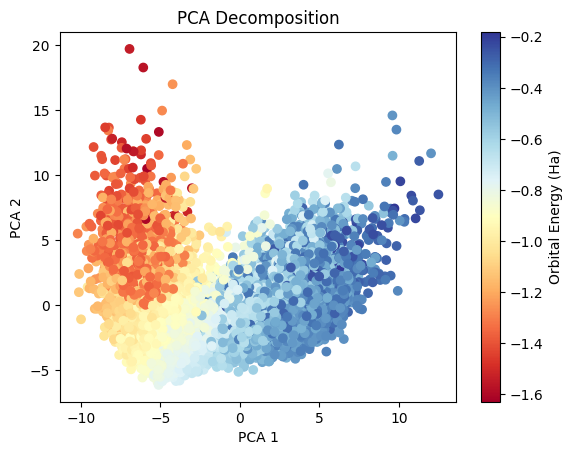

In [9]:
import numpy as np #
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
A = pca.fit_transform(Xtot)
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(A[:,0],A[:,1],c=ytot,cmap=cm)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Decomposition") #Eh?
cbar = plt.colorbar(sc)
cbar.set_label("Orbital Energy (Ha)")

## Molecular Post-Energy

In [11]:
import os
import numpy as np
import glob
import torch
import time
from cace.cace.tools import scatter_sum
from cace.cace.tasks import LightningTrainingTask
from deeporb.data import OrbDataset, OrbData
from deeporb.ceonet import CEONet

#data
root = "data/aocart_occ.h5"
cutoff = 4.0
avge0 = -0.6637
sigma = 0.2863
data = OrbData(root=root,batch_size=128,cutoff=cutoff,avge0=avge0,sigma=sigma,in_memory=False)

representation = CEONet(64,cutoff=cutoff,n_rbf=8,n_rsamples=8,lomax=2,layers=4)

from cace.cace.models import NeuralNetworkPotential
from deeporb.atomwise import Atomwise, AttentionAtomwise
atomwise = AttentionAtomwise(
                    output_key='molecular_rep',
                    n_hidden=[32,16],
                    attention_hidden_nc=128,
                    avge0=avge0,sigma=sigma,
                    bias=True
                   )

model = NeuralNetworkPotential(
    input_modules=None,
    representation=representation,
    output_modules=[atomwise]
)

chkpt = "/home/king1305/ORBITAL_LABELING/model_eval/gathered_logs/ceonet_occ/version_1/checkpoints/epoch=499-step=424500.ckpt"
task = LightningTrainingTask(model)
task.load(chkpt)

#Generate atomic representations
Xtot_post = []
task.model.eval().cuda()
with torch.no_grad():
    for batch in data.val_dataloader():
        batch.cuda()
        dct = task.model.forward(batch)
        Xtot_post.append(dct["molecular_rep"].cpu().detach().numpy())
torch.cuda.empty_cache()
Xtot_post = np.vstack(Xtot_post)
Xtot_post.shape

Loading model from /home/king1305/ORBITAL_LABELING/model_eval/gathered_logs/ceonet_occ/version_1/checkpoints/epoch=499-step=424500.ckpt ...
Loading successful!


(12032, 128)

/tmp/ipykernel_3796498/1637645573.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


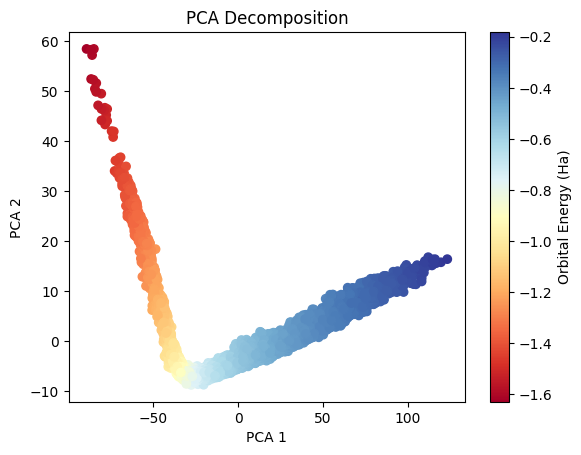

In [12]:
import numpy as np #
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
A = pca.fit_transform(Xtot_post)
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(A[:,0],A[:,1],c=ytot,cmap=cm)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Decomposition") #Eh?
cbar = plt.colorbar(sc)
cbar.set_label("Orbital Energy (Ha)")

## Atomic Features

In [18]:
import os
import numpy as np
import glob
import torch
import time
from cace.cace.tools import scatter_sum
from cace.cace.tasks import LightningTrainingTask
from deeporb.data import OrbDataset, OrbData
from deeporb.ceonet import CEONet

#data
root = "data/aocart_occ.h5"
cutoff = 4.0
avge0 = -0.6637
sigma = 0.2863
data = OrbData(root=root,batch_size=128,cutoff=cutoff,avge0=avge0,sigma=sigma,in_memory=False)

representation = CEONet(64,cutoff=cutoff,n_rbf=8,n_rsamples=8,lomax=2,layers=4)

from cace.cace.models import NeuralNetworkPotential
from deeporb.atomwise import Atomwise, AttentionAtomwise
atomwise = AttentionAtomwise(
                    output_key='pred_energy',
                    n_hidden=[32,16],
                    attention_hidden_nc=128,
                    avge0=avge0,sigma=sigma,
                    bias=True
                   )

model = NeuralNetworkPotential(
    input_modules=None,
    representation=representation,
    output_modules=[atomwise]
)

chkpt = "/home/king1305/ORBITAL_LABELING/model_eval/gathered_logs/ceonet_occ/version_1/checkpoints/epoch=499-step=424500.ckpt"
task = LightningTrainingTask(model)
task.load(chkpt)

#Generate atomic representations
task.model.eval().cuda()
Xatom = []
atm_nums = []
with torch.no_grad():
    for batch in data.val_dataloader():
        batch.cuda()
        atm_nums.append(batch["atomic_numbers"].cpu().detach().numpy())
        dct = task.model.model.representation(batch)
        Xatom.append(dct["node_feats"].cpu().detach().numpy())
del dct
torch.cuda.empty_cache()

Xatom = np.vstack(Xatom)
atm_nums = np.hstack(atm_nums)
Xatom.shape , atm_nums.shape

Loading model from /home/king1305/ORBITAL_LABELING/model_eval/gathered_logs/ceonet_occ/version_1/checkpoints/epoch=499-step=424500.ckpt ...
Loading successful!


((219115, 1280), (219115,))

In [38]:
import numpy as np #
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
A = pca.fit_transform(Xatom)
print("pca.explained_variance_ratio_")

Text(0.5, 1.0, 'Atomic PCA')

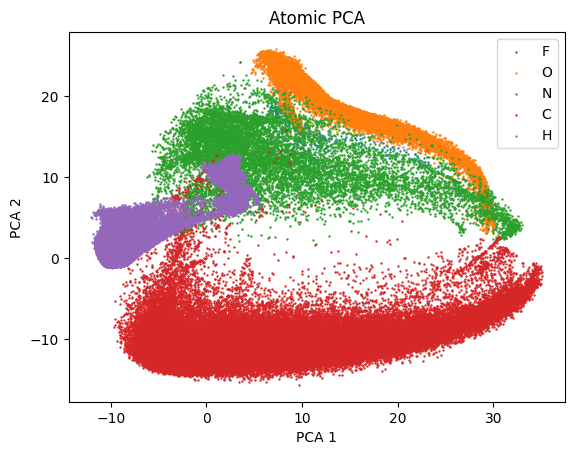

In [37]:
trans = {1:"H",6:"C",7:"N",8:"O",9:"F"}
for el in representation.zs[::-1]:
    idx = np.where(atm_nums == el)[0]
    plt.scatter(A[idx,0],A[idx,1],label=trans[el],s=0.5)
    plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"Atomic PCA")

Text(0.5, 1.0, 'H PCA')

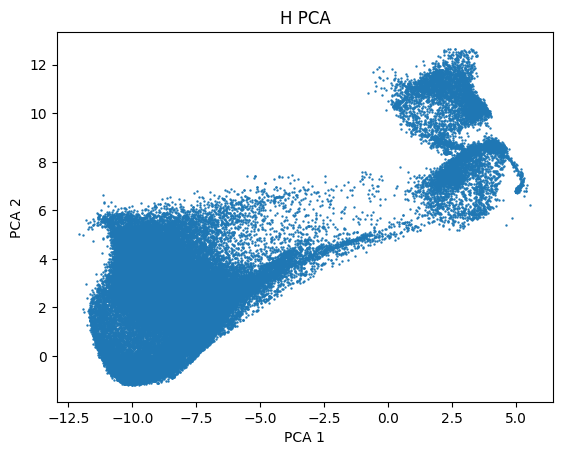

In [31]:
el = 1
idx = np.where(atm_nums == el)[0]
plt.scatter(A[idx,0],A[idx,1],label=el,s=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"{trans[el]} PCA")